In [12]:
! pip uninstall -y gym gymnasium ale-py autorom
! pip install gym[atari]==0.21.0
! pip install autorom[accept-rom-license]

Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Found existing installation: gymnasium 0.29.0
Uninstalling gymnasium-0.29.0:
  Successfully uninstalled gymnasium-0.29.0
Found existing installation: ale-py 0.7.5
Uninstalling ale-py-0.7.5:
  Successfully uninstalled ale-py-0.7.5
Found existing installation: AutoROM 0.6.1
Uninstalling AutoROM-0.6.1:
  Successfully uninstalled AutoROM-0.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.2 MB/s eta 0:00:00a 0:00:01
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See a

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


Training CartPole agent...
Episode: 0, Score: 44.0, Avg Score: 44.00, Epsilon: 0.80
Episode: 100, Score: 11.0, Avg Score: 23.05, Epsilon: 0.01
Episode: 200, Score: 9.0, Avg Score: 22.76, Epsilon: 0.01
Episode: 300, Score: 16.0, Avg Score: 26.61, Epsilon: 0.01
Episode: 400, Score: 9.0, Avg Score: 28.72, Epsilon: 0.01
Episode: 500, Score: 141.0, Avg Score: 26.28, Epsilon: 0.01
Episode: 600, Score: 11.0, Avg Score: 19.17, Epsilon: 0.01
Episode: 700, Score: 8.0, Avg Score: 23.15, Epsilon: 0.01
Episode: 800, Score: 32.0, Avg Score: 24.95, Epsilon: 0.01
Episode: 900, Score: 9.0, Avg Score: 20.55, Epsilon: 0.01


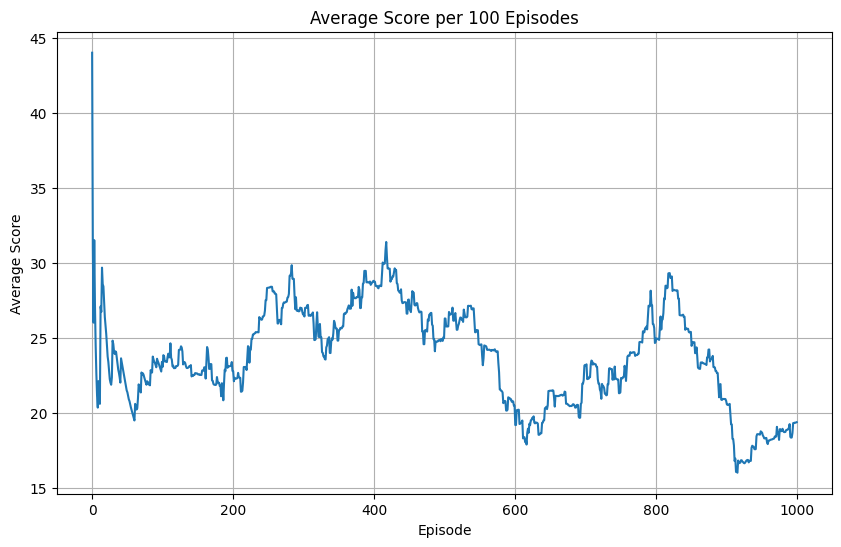


Testing trained agent:
Test Episode: 0, Score: 8.0
Test Episode: 1, Score: 20.0
Test Episode: 2, Score: 9.0
Test Episode: 3, Score: 9.0
Test Episode: 4, Score: 9.0


In [17]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import time

class CartPoleAgent:
    def __init__(self, state_size, action_size, discretize_bins=10):
        self.state_size = state_size
        self.action_size = action_size
        self.bins = discretize_bins
        
        # Discretization parameters for state space
        self.upper_bounds = [2.4, 10, 0.418, 10]  # cart position, velocity, pole angle, pole velocity
        self.lower_bounds = [-2.4, -10, -0.418, -10]
        
        # Q-learning parameters
        self.learning_rate = 0.1
        self.discount_factor = 0.99
        self.epsilon = 1.0  # Start with 100% exploration
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
        # Create Q-table
        self.q_table = np.zeros(([self.bins] * state_size) + [action_size])
        
    def discretize_state(self, state):
        """Convert continuous state to discrete state index"""
        discrete_state = []
        for i in range(len(state)):
            # Clip state to bounds
            state_val = max(min(state[i], self.upper_bounds[i]), self.lower_bounds[i])
            # Compute bin index
            scaling = (state_val - self.lower_bounds[i]) / (self.upper_bounds[i] - self.lower_bounds[i])
            bin_index = min(int(scaling * self.bins), self.bins - 1)
            discrete_state.append(bin_index)
        return tuple(discrete_state)
    
    def choose_action(self, state):
        """Choose action using epsilon-greedy policy"""
        if np.random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            discrete_state = self.discretize_state(state)
            return np.argmax(self.q_table[discrete_state])
            
    def learn(self, state, action, reward, next_state, done):
        """Update Q-table using Q-learning update rule"""
        discrete_state = self.discretize_state(state)
        next_discrete_state = self.discretize_state(next_state)
        
        # Q-learning update
        best_next_action = np.argmax(self.q_table[next_discrete_state])
        current_q = self.q_table[discrete_state + (action,)]
        
        if done:
            # If episode is done, just use the reward
            new_q = current_q + self.learning_rate * (reward - current_q)
        else:
            # Q-learning formula
            next_q = self.q_table[next_discrete_state + (best_next_action,)]
            new_q = current_q + self.learning_rate * (reward + self.discount_factor * next_q - current_q)
        
        # Update the Q-table
        self.q_table[discrete_state + (action,)] = new_q
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_agent(episodes=2000, max_steps=500, render=False):
    # Create environment and agent
    env = gym.make('CartPole-v1')
    agent = CartPoleAgent(state_size=4, action_size=2)
    
    # Track performance
    scores = deque(maxlen=100)
    avg_scores = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        
        for step in range(max_steps):
            # Choose and perform action
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            
            # Learn from experience
            agent.learn(state, action, reward, next_state, done)
            
            # Update state and accumulate reward
            state = next_state
            total_reward += reward
            
            if done:
                break
                
        # Track performance
        scores.append(total_reward)
        avg_score = np.mean(scores)
        avg_scores.append(avg_score)
        
        # Print progress
        if episode % 100 == 0:
            print(f"Episode: {episode}, Score: {total_reward}, Avg Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.2f}")
            
    # Close environment
    env.close()
    return agent, avg_scores

def test_agent(agent, episodes=10):
    env = gym.make('CartPole-v1')
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            # Choose best action (no exploration)
            discrete_state = agent.discretize_state(state)
            action = np.argmax(agent.q_table[discrete_state])
            
            # Take action
            state, reward, done, _ = env.step(action)
            total_reward += reward
                
        print(f"Test Episode: {episode}, Score: {total_reward}")
    
    env.close()

def plot_learning_curve(scores):
    plt.figure(figsize=(10, 6))
    plt.plot(scores)
    plt.title('Average Score per 100 Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Average Score')
    plt.grid(True)
    plt.show()

# Make sure the gym package is installed
try:
    import pip
    import subprocess
    import sys
    
    # Check if gym is installed, if not, install it
    try:
        import gym
    except ImportError:
        print("Installing gym package...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "gym"])
        import gym
        print("Gym installed successfully!")
except Exception as e:
    print(f"Error with package installation: {e}")

if __name__ == "__main__":
    print("Training CartPole agent...")
    try:
        agent, avg_scores = train_agent(episodes=1000)  # Reduced episodes for faster training
        
        # Plot learning curve
        plot_learning_curve(avg_scores)
        
        # Test the trained agent
        print("\nTesting trained agent:")
        test_agent(agent, episodes=5)
    except Exception as e:
        print(f"Error during training: {e}")
        

In [3]:
pip install stable-baselines3[extra] gymnasium[atari] gymnasium[accept-rom-license] opencv-python

INFO: pip is looking at multiple versions of gymnasium[atari] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of gymnasium[atari] to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of gymnasium[accept-rom-license] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 23.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: gymnas

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.target_model.predict(next_state, verbose=0)[0]))
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

def verify_environment():
    """Verify that the basic gymnasium environments work"""
    try:
        # Try creating environment with different API versions to handle compatibility
        try:
            env = gym.make('CartPole-v1')
        except (TypeError, ValueError):
            # Fall back to older version API if needed
            env = gym.make('CartPole-v1', render_mode=None)
            
        print("✓ Successfully created CartPole environment")
        print(f"Observation space: {env.observation_space}")
        print(f"Action space: {env.action_space}")
        env.close()
        return True
    except Exception as e:
        print(f"✗ Error creating environment: {e}")
        print("\nTry upgrading gymnasium:")
        print("pip install --upgrade gymnasium")
        return False

def train_dqn():
    # Create environment - with compatibility for different gymnasium versions
    try:
        env = gym.make('CartPole-v1')
    except (TypeError, ValueError):
        env = gym.make('CartPole-v1', render_mode=None)
        
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    batch_size = 32
    
    # Create directory for models
    os.makedirs("./models", exist_ok=True)
    
    # Training settings
    episodes = 500
    target_update_frequency = 50  # Update target network every n episodes
    scores = []
    
    for e in range(1, episodes+1):
        # Reset environment with compatibility for different gymnasium versions
        try:
            state, _ = env.reset()
        except ValueError:
            state = env.reset()
            
        state = np.reshape(state, [1, state_size])
        
        done = False
        score = 0
        
        while not done:
            # Choose action
            action = agent.act(state)
            
            # Take action with compatibility for different gymnasium versions
            try:
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
            except ValueError:
                next_state, reward, done, _ = env.step(action)
            
            # Reshape state for model input
            next_state = np.reshape(next_state, [1, state_size])
            
            # Remember experience
            agent.remember(state, action, reward, next_state, done)
            
            # Update state and score
            state = next_state
            score += 1
            
            # End episode if done
            if done:
                print(f"Episode: {e}/{episodes}, Score: {score}, Epsilon: {agent.epsilon:.2f}")
                scores.append(score)
                
                # Update target network periodically
                if e % target_update_frequency == 0:
                    agent.update_target_model()
                    print(f"Updated target model at episode {e}")
                break
                
            # Train the agent with a batch of experiences
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        
        # Save model weights every 100 episodes
        if e % 100 == 0:
            agent.save(f"./models/cartpole_dqn_{e}.h5")
            print(f"Model saved at episode {e}")
    
    # Save final model
    agent.save("./models/cartpole_dqn_final.h5")
    
    # Plot training progress
    plt.figure(figsize=(10, 6))
    plt.plot(scores)
    plt.title('DQN Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.savefig('./training_progress.png')
    plt.show()
    
    return agent, env, scores

def play_and_render(agent, episodes=5):
    """Play the game with the trained agent and render it"""
    try:
        env = gym.make('CartPole-v1', render_mode='human')
    except (TypeError, ValueError):
        # Fallback for older gymnasium versions
        env = gym.make('CartPole-v1')
        env.render_mode = 'human'
    
    state_size = env.observation_space.shape[0]
    
    for e in range(episodes):
        try:
            state, _ = env.reset()
        except ValueError:
            state = env.reset()
            
        state = np.reshape(state, [1, state_size])
        done = False
        score = 0
        
        while not done:
            # Agent selects action
            action = agent.act(state)
            
            # Take action
            try:
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
            except ValueError:
                next_state, reward, done, _ = env.step(action)
            
            # Update state and score
            next_state = np.reshape(next_state, [1, state_size])
            state = next_state
            score += 1
            
            if done:
                print(f"Episode: {e+1}, Score: {score}")
                break
    
    env.close()

def main():
    # Verify that gymnasium works
    if not verify_environment():
        print("Failed to create environment. Please check your Gymnasium installation.")
        return
    
    print("\nStarting DQN training on CartPole...")
    agent, env, scores = train_dqn()
    env.close()
    
    print("\nTraining complete!")
    print(f"Final 10 episode average score: {np.mean(scores[-10:]):.2f}")
    
    # Play and render
    print("\nPlaying CartPole with the trained agent...")
    play_and_render(agent)
    
    print("Done!")

if __name__ == "__main__":
    main()

✗ Error creating environment: cannot import name 'AutoresetMode' from 'gymnasium.vector' (/usr/local/lib/python3.10/dist-packages/gymnasium/vector/__init__.py)

Try upgrading gymnasium:
pip install --upgrade gymnasium
Failed to create environment. Please check your Gymnasium installation.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import gym  # Using classic OpenAI Gym instead of Gymnasium
from collections import deque
import random
import matplotlib.pyplot as plt

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.target_model.predict(next_state, verbose=0)[0]))
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

def verify_environment():
    """Verify that the basic gym environments work"""
    try:
        env = gym.make('CartPole-v1')
        print("✓ Successfully created CartPole environment")
        print(f"Observation space: {env.observation_space}")
        print(f"Action space: {env.action_space}")
        env.close()
        return True
    except Exception as e:
        print(f"✗ Error creating environment: {e}")
        print("\nTry installing OpenAI Gym:")
        print("pip install gym")
        return False

def train_dqn():
    # Create environment
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    batch_size = 32
    
    # Create directory for models
    os.makedirs("./models", exist_ok=True)
    
    # Training settings
    episodes = 500
    target_update_frequency = 50  # Update target network every n episodes
    scores = []
    
    for e in range(1, episodes+1):
        # Reset environment
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        
        done = False
        score = 0
        
        while not done:
            # Choose action
            action = agent.act(state)
            
            # Take action
            next_state, reward, done, _ = env.step(action)
            
            # Reshape state for model input
            next_state = np.reshape(next_state, [1, state_size])
            
            # Remember experience
            agent.remember(state, action, reward, next_state, done)
            
            # Update state and score
            state = next_state
            score += 1
            
            # End episode if done
            if done:
                print(f"Episode: {e}/{episodes}, Score: {score}, Epsilon: {agent.epsilon:.2f}")
                scores.append(score)
                
                # Update target network periodically
                if e % target_update_frequency == 0:
                    agent.update_target_model()
                    print(f"Updated target model at episode {e}")
                break
                
            # Train the agent with a batch of experiences
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        
        # Save model weights every 100 episodes
        if e % 100 == 0:
            agent.save(f"./models/cartpole_dqn_{e}.h5")
            print(f"Model saved at episode {e}")
    
    # Save final model
    agent.save("./models/cartpole_dqn_final.h5")
    
    # Plot training progress
    plt.figure(figsize=(10, 6))
    plt.plot(scores)
    plt.title('DQN Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.savefig('./training_progress.png')
    plt.show()
    
    return agent, env, scores

def play_and_render(agent, episodes=5):
    """Play the game with the trained agent and render it"""
    env = gym.make('CartPole-v1', render_mode='human')
    state_size = env.observation_space.shape[0]
    
    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        done = False
        score = 0
        
        while not done:
            # Agent selects action
            action = agent.act(state)
            
            # Take action
            next_state, reward, done, _ = env.step(action)
            
            # Update state and score
            next_state = np.reshape(next_state, [1, state_size])
            state = next_state
            score += 1
            
            if done:
                print(f"Episode: {e+1}, Score: {score}")
                break
    
    env.close()

def main():
    # Verify that gym works
    if not verify_environment():
        print("Failed to create environment. Please check your OpenAI Gym installation.")
        return
    
    print("\nStarting DQN training on CartPole...")
    agent, env, scores = train_dqn()
    env.close()
    
    print("\nTraining complete!")
    print(f"Final 10 episode average score: {np.mean(scores[-10:]):.2f}")
    
    # Play and render
    print("\nPlaying CartPole with the trained agent...")
    try:
        play_and_render(agent)
    except Exception as e:
        print(f"Rendering failed: {e}")
        print("This is common in environments without display access")
    
    print("Done!")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_check

✓ Successfully created CartPole environment
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)

Starting DQN training on CartPole...
Episode: 1/500, Score: 10, Epsilon: 1.00
Episode: 2/500, Score: 23, Epsilon: 1.00
Episode: 3/500, Score: 17, Epsilon: 0.92
Episode: 4/500, Score: 15, Epsilon: 0.86
Episode: 5/500, Score: 43, Epsilon: 0.70
Episode: 6/500, Score: 34, Epsilon: 0.59
Episode: 7/500, Score: 43, Epsilon: 0.48
Episode: 8/500, Score: 31, Epsilon: 0.41
Episode: 9/500, Score: 30, Epsilon: 0.36
Episode: 10/500, Score: 25, Epsilon: 0.32
Episode: 11/500, Score: 64, Epsilon: 0.23
Episode: 12/500, Score: 63, Epsilon: 0.17
Episode: 13/500, Score: 40, Epsilon: 0.14
Episode: 14/500, Score: 66, Epsilon: 0.10
Episode: 15/500, Score: 29, Epsilon: 0.09
Episode: 16/500, Score: 35, Epsilon: 0.07
Episode: 17/500, Score: 36, Epsilon: 0.06
Episode: 18/500, Score: 42,